# Ojective
To classify a given new review eithe positive or negative  using **Decision trees**  technqiue.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Loading libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Reading data

In [4]:
df=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/data.csv')
print(df.shape)
df.columns

(100000, 12)


Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'Class'],
      dtype='object')

# Train and test dataset
Dataset is diveided into two parts in which 67% data is train data and 33% of the data is test data which is used to validate the performance of the dataset

In [5]:
from sklearn.model_selection import train_test_split
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df['Text'],df['Class'],test_size=0.33,shuffle=False)
print(df_train_x.shape,df_test_x.shape,df_train_y.shape,df_test_y.shape)

(67000,) (33000,) (67000,) (33000,)


# draw random and grid search reulsts

In [0]:
import ast
from IPython.display import display, HTML
def read_table_data(filename):
    filename="/content/drive/My Drive/Colab_Notebooks/SVM/"+filename
    x=pd.read_csv(filename)
    alpha_value=[]
    regularization=[]
    cv_score=[]
    for x1 in x[['params','mean_test_score']].values:
        #print(x1)
        a=ast.literal_eval(x1[0])
        cv_score.append(x1[1])
        alpha_value.append(a['alpha'])
        regularization.append(a['penalty'])
    results=pd.DataFrame({'alpha_value':alpha_value,'regularization':regularization,'cv_score':cv_score})
    zz=results.sort_values(by=['cv_score','regularization'],ascending=False)
    display(zz)

# Feature importance function

In [0]:
!pip install beautifultable
from beautifultable import BeautifulTable
def feature_importance(models_list,word_model):
  #words=[]
  index=0
  table=BeautifulTable()
  for model in models_list:
    scores=model.feature_importances_
    indices=np.argsort(scores)[-20:]
    words=[word_model.get_feature_names()[i] for i in np.argsort(scores)[-20:]]
    table.insert_column(index,"Important features model "+str(index),words)
    index=index+1
  print("Top 20 Important features")
  print(table)
  #print(words)
  

#  plot confusion matrix function

In [0]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score
cms=[]
#depth=[350,700,1150]
def plot_confusion_matrix(depth,output,output1,output2):
  cm=confusion_matrix(df_test_y,output)
  cm1=confusion_matrix(df_test_y,output1)
  cm2=confusion_matrix(df_test_y,output2)
  cms.append(cm);cms.append(cm1);cms.append(cm2)
  dataframes=[]
  for item in cms:
    dataframes.append(pd.DataFrame(item,index=['negative','positive'],columns=['negative','positive']))   
  fig, axes = plt.subplots(2,2,figsize=(10,5))
  axes= axes.flatten()
  index=0
  for ax in axes:
    if(index<3):
      sb.heatmap(dataframes[index], annot=True, fmt='g',ax=ax)
      #col.title.set_text('L2-regularizatiton with C='+str(C_values[i]))
      ax.set_xlabel('Predicted label')
      ax.title.set_text('Depth of tree='+str(depth[index]))
      ax.set_ylabel('True label')
      index+=1
    else:
      ax.set_visible(False)
      print('done with confusion matrices')

# plot the table

In [0]:
from sklearn.metrics import f1_score,accuracy_score
def plot_table(depth,output,output1,output2):
  precision_scores=[];recall_scores=[];f1_scores=[];accuracies=[];
  outputs=[output,output1,output2]
  for item in outputs:
    precision_scores.append(precision_score(df_test_y,item))
    recall_scores.append(recall_score(df_test_y,item))
    f1_scores.append(f1_score(df_test_y,item))
    accuracies.append(accuracy_score(df_test_y,item))
  from beautifultable import BeautifulTable
  table=BeautifulTable()
  table.insert_column(0,"precision",precision_scores)
  table.insert_column(1,"recall",recall_scores)
  table.insert_column(2,"accuracy",accuracies)
  table.insert_column(3,"f1-score",f1_scores)
  table.insert_column(4,"depth",depth)
  sorted_table=table.sort('depth')
  print(table) 

# Bag of words - unigrams

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
bow_unigrams=CountVectorizer(stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [0]:
#Label encoder from positive negative to 1,0
from sklearn import preprocessing
bin=preprocessing.LabelEncoder()
df_train_y=bin.fit_transform(df_train_y)
df_test_y=bin.fit_transform(df_test_y)

In [0]:
from sklearn.model_selection import cross_val_score
#print(test_data.shape)
from sklearn.tree import DecisionTreeClassifier

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,30):
  decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  #result=cross_val_score(decision_tree,train_data,df_train_y,cv=3)
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
  

In [0]:
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.head()
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_unigrams_gini_time.csv")

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,30):
  decision_tree=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  #result=cross_val_score(decision_tree,train_data,df_train_y,cv=3)
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
  

**Here,for  depth of a decision tree  I have tried with values with 1 to 30 and ploted the graph with x-axis no.of iterations and y-axis as error **

In [0]:
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.head()
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_unigrams_entropy_time.csv")

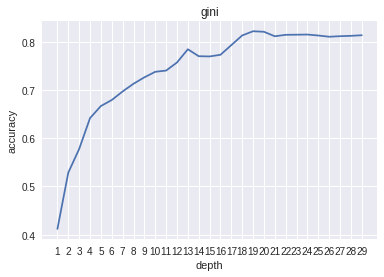

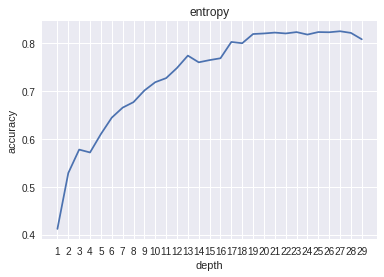

In [57]:
data=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_unigrams_gini_time.csv')
data1=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_unigrams_entropy_time.csv')
plot_graph(data,'gini')
plot_graph(data1,'entropy')

**For the depth 18,19,20 we are getting low error rate among all possible values of depth , so lets try these values**

In [0]:
def plot_graph(data,name):
  depth=data['depth']
  scores=data['scores']
  import matplotlib.pyplot as plt
  #fig,(ax1,ax2)=plt.subplots(1,2,figsize(10,5))
  #error=scores
  #error=100-(error*100)
  #plt.xlim(1,30)
  plt.xticks(range(1,30))
  plt.title(name)
  plt.xlabel('depth')
  plt.ylabel('accuracy')
  plt.plot(depth,scores)
  plt.show()

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=18, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model=decision_tree.fit(train_data,df_train_y)
output=model.predict(test_data)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=19, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model1=decision_tree.fit(train_data,df_train_y)
output1=model1.predict(test_data)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model2=decision_tree.fit(train_data,df_train_y)
output2=model2.predict(test_data)

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


done with confusion matrices
+-----------+--------+----------+----------+-------+
| precision | recall | accuracy | f1-score | depth |
+-----------+--------+----------+----------+-------+
|   0.947   |  0.72  |   0.72   |  0.818   |  18   |
+-----------+--------+----------+----------+-------+
|   0.945   | 0.733  |  0.729   |  0.826   |  19   |
+-----------+--------+----------+----------+-------+
|   0.948   | 0.718  |  0.719   |  0.817   |  20   |
+-----------+--------+----------+----------+-------+
Top 20 Important features
+-------------------------+-------------------------+-------------------------+
| Important features mode | Important features mode | Important features mode |
|           l 0           |           l 1           |           l 2           |
+-------------------------+-------------------------+-------------------------+
|      unfortunately      |      unfortunately      |         product         |
+-------------------------+-------------------------+---------------

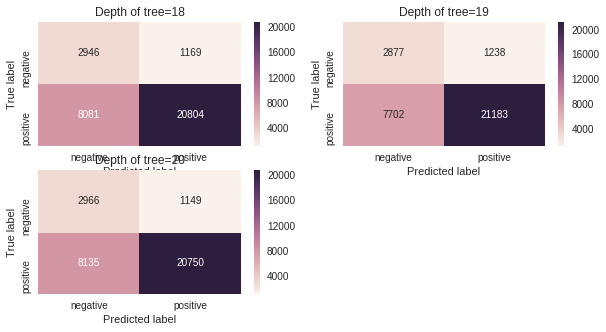

In [34]:
#!pip install beautifultable
depth=[18,19,20]
plot_confusion_matrix(depth,output,output1,output2)
plot_table(depth,output,output1,output2)
feature_importance([model,model1,model2],BOW1_train)

**The models  precision score is around 95% and recall score is around 76% **

In [52]:
#!apt-get install graphviz
#!pip install graphviz
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model2, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("/content/drive/My Drive/Colab_Notebooks/Decision_trees/plot") 

/usr/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 885 is still running
  ResourceWarning, source=self)


'/content/drive/My Drive/Colab_Notebooks/Decision_trees/plot.pdf'

In [51]:
dot_data = tree.export_graphviz(model2, out_file='/content/drive/My Drive/Colab_Notebooks/Decision_trees/plot.dot',
                         feature_names=BOW1_train.get_feature_names(),  
                         class_names=['negative','positive'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
!dot -Tps '/content/drive/My Drive/Colab_Notebooks/Decision_trees/plot.dot' -o '/content/drive/My Drive/Colab_Notebooks/Decision_trees/outfile.png' 

# Bag of words - Bigrams

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
bow_unigrams=CountVectorizer(ngram_range=(1,2),stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  #result=cross_val_score(decision_tree,train_data,df_train_y,cv=3)
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
  

In [0]:
decision_tree=pd.DataFrame({'depth':depth,'score':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_biigrams_gini.csv")

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  #result=cross_val_score(decision_tree,train_data,df_train_y,cv=3)
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'score':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_biigrams_entropy.csv")

Index(['Unnamed: 0', 'depth', 'score'], dtype='object') Index(['Unnamed: 0', 'depth', 'score'], dtype='object')


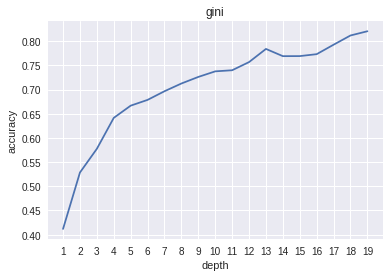

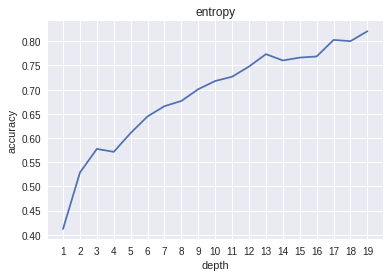

In [22]:
data=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_biigrams_gini.csv')
data1=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/bow_biigrams_entropy.csv')
print(data.columns,data1.columns)
data.columns=['index','depth','scores']
data1.columns=['index','depth','scores']
plot_graph(data,'gini')
plot_graph(data1,'entropy')

**For the depth 19 we are getting low error rate among all possible values of depth , so lets try these values**

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=19, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model=decision_tree.fit(train_data,df_train_y)
output=model.predict(test_data)

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------+--------+----------+-------+----------+
| precision | recall | f1_score | depth | accuracy |
+-----------+--------+----------+-------+----------+
|   0.945   | 0.733  |  0.826   |  700  |  0.729   |
+-----------+--------+----------+-------+----------+


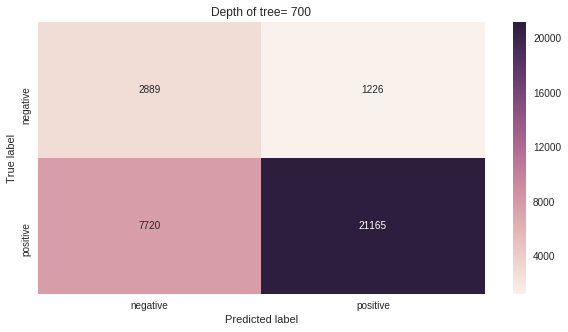

In [26]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from beautifultable import BeautifulTable
#Label encoder from positive negative to 1,0
from sklearn import preprocessing
bin=preprocessing.LabelEncoder()
output=bin.fit_transform(output)

cm=confusion_matrix(df_test_y,output)
dataframes=pd.DataFrame(cm,index=['negative','positive'],columns=['negative','positive'])  
fig, axes = plt.subplots(1,1,figsize=(10,5))
sb.heatmap(dataframes, annot=True, fmt='g',ax=axes)
#col.title.set_text('L2-regularizatiton with C='+str(C_values[i]))
axes.set_xlabel('Predicted label')
axes.title.set_text('Depth of tree= 700')
axes.set_ylabel('True label')
table=BeautifulTable()
table.insert_column(0,"precision",[precision_score(df_test_y,output)])
table.insert_column(1,"recall",[recall_score(df_test_y,output)])
table.insert_column(2,"accuracy",[accuracy_score(df_test_y,output)])
table.insert_column(2,"f1_score",[f1_score(df_test_y,output)])
table.insert_column(3,"depth",[700])
print(table)

**The models precision score is around  94 and f1 score is  score is 83%**



In [56]:
feature_importance([model],BOW1_train)

Top 20 Important features
+----------------------------+
| Important features model 0 |
+----------------------------+
|            like            |
+----------------------------+
|            did             |
+----------------------------+
|            easy            |
+----------------------------+
|           awful            |
+----------------------------+
|            nice            |
+----------------------------+
|           tasty            |
+----------------------------+
|           money            |
+----------------------------+
|          favorite          |
+----------------------------+
|            bad             |
+----------------------------+
|         wonderful          |
+----------------------------+
|        disappointed        |
+----------------------------+
|         excellent          |
+----------------------------+
|          thought           |
+----------------------------+
|           loves            |
+----------------------------+
|            

# Tf_idf Unigrams

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(stop_words='english')
tfidf1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_unigrams_entropy.csv")

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_unigrams_gini.csv")

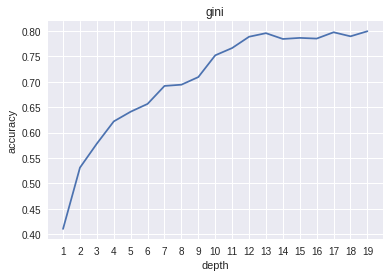

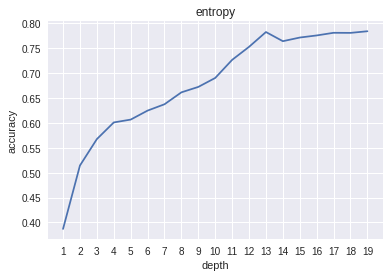

In [18]:
data=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_unigrams_gini.csv')
data1=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_unigrams_entropy.csv')
plot_graph(data,'gini')
plot_graph(data1,'entropy')

****For the depth13,17,19 we are getting low error rate among all possible values of depth , so lets try these values****

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=13, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model=decision_tree.fit(train_data,df_train_y)
output=model.predict(test_data)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=17, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model1=decision_tree.fit(train_data,df_train_y)
output1=model1.predict(test_data)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=19, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model2=decision_tree.fit(train_data,df_train_y)
output2=model2.predict(test_data)

done with confusion matrices
+-----------+--------+----------+----------+-------+
| precision | recall | accuracy | f1-score | depth |
+-----------+--------+----------+----------+-------+
|   0.951   | 0.679  |  0.689   |  0.793   |  13   |
+-----------+--------+----------+----------+-------+
|   0.952   | 0.689  |  0.697   |  0.799   |  17   |
+-----------+--------+----------+----------+-------+
|   0.949   |  0.7   |  0.704   |  0.806   |  19   |
+-----------+--------+----------+----------+-------+
Top 20 Important features
+-------------------------+-------------------------+-------------------------+
| Important features mode | Important features mode | Important features mode |
|           l 0           |           l 1           |           l 2           |
+-------------------------+-------------------------+-------------------------+
|          money          |         highly          |          easy           |
+-------------------------+-------------------------+---------------

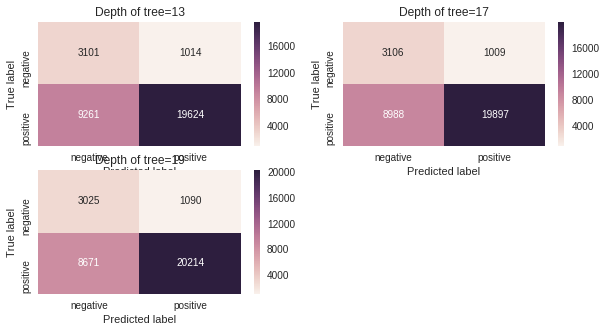

In [23]:
depth=[13,17,19]
plot_confusion_matrix(depth,output,output1,output2)
plot_table(depth,output,output1,output2)
feature_importance([model,model1,model2],tfidf1_train)

**The models precision score is around 95% and recall score is 80% which means among true 100 reviews the model is able to predict 80% them correctly**

# TF-IDF bigrams

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(ngram_range=(1,2),stop_words='english')
tfidf1_train=bow_unigrams.fit(df_train_x)
train_data=bow_unigrams.transform(df_train_x)
test_data=bow_unigrams.transform(df_test_x)
print("The train data shape is ",train_data.shape,"and test data shape is ",test_data.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_Bigrams_entropy.csv")

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,20):
  decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_data):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_Bigrams_gini.csv")

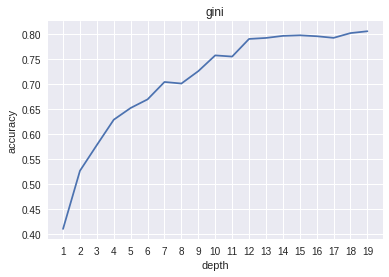

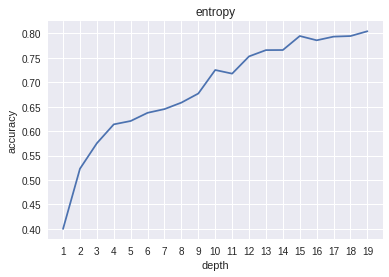

In [27]:
data=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_Bigrams_gini.csv')
data1=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/tf_idf_Bigrams_entropy.csv')
plot_graph(data,'gini')
plot_graph(data1,'entropy')

**At the depth=19 we are getting low error in the cross validation **

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=19, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model=decision_tree.fit(train_data,df_train_y)
output=model.predict(test_data)


/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


+-----------+--------+----------+----------+-------+
| precision | recall | f1_score | accuracy | depth |
+-----------+--------+----------+----------+-------+
|   0.949   | 0.701  |  0.807   |  0.706   |  19   |
+-----------+--------+----------+----------+-------+


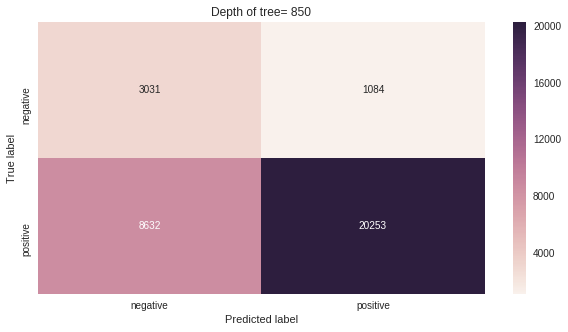

In [32]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from beautifultable import BeautifulTable
#Label encoder from positive negative to 1,0
from sklearn import preprocessing
bin=preprocessing.LabelEncoder()
output=bin.fit_transform(output)

cm=confusion_matrix(df_test_y,output)
dataframes=pd.DataFrame(cm,index=['negative','positive'],columns=['negative','positive'])  
fig, axes = plt.subplots(1,1,figsize=(10,5))
sb.heatmap(dataframes, annot=True, fmt='g',ax=axes)
#col.title.set_text('L2-regularizatiton with C='+str(C_values[i]))
axes.set_xlabel('Predicted label')
axes.title.set_text('Depth of tree= 850')
axes.set_ylabel('True label')
table=BeautifulTable()
table.insert_column(0,"precision",[precision_score(df_test_y,output)])
table.insert_column(1,"recall",[recall_score(df_test_y,output)])
table.insert_column(3,"accuracy",[accuracy_score(df_test_y,output)])
table.insert_column(2,"f1_score",[f1_score(df_test_y,output)])
table.insert_column(4,"depth",[19])
print(table)

**The models precision score is around 95% and f1_score is 81% which means among true 100 reviews the model is able to predict 81% them correctly**

# word2vec model

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tf_idf_model=TfidfVectorizer(stop_words='english')
stop_words = tf_idf_model.get_stop_words()
model=[]   #df_train_x.shape,df_test_x.shape,df_train_y.shape,df_test_y.shape
for sent in df_train_x:
    temp=[]
    for word in sent.split():
        if word not in stop_words:
            temp.append(word)
    model.append(temp)
print(model[0][0:10])

['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving']


In [0]:
!pip install gensim
from gensim.models import Word2Vec
amazon_model = Word2Vec(model, size=300, window=5, min_count=1, workers=4)

In [0]:
import numpy as np
word_vectors = amazon_model.wv
train_vec=[]
counter=0
for sentence in df_train_x:
    temp=np.zeros(300)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        else:
            #print(word," is not presnet in training model of word2vec")
            pass
        length+=1
    train_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

In [0]:
import numpy as np
word_vectors = amazon_model.wv
test_vec=[]
counter=0
for sentence in df_test_x:
    temp=np.zeros(300)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        else:
            pass# print(word," is not presnet in training model of word2vec")
        length+=1
    test_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,30):
  decision_tree=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_vec):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/word2vec_entropy.csv")

In [0]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
scores=[]
depth=[]
for i in range(1,30):
  decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
  tscv = TimeSeriesSplit(n_splits=3)
  cv_score=[]
  for train_index, test_index in tscv.split(train_vec):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = df_train_y[train_index], df_train_y[test_index]
    model=decision_tree.fit(X_train,y_train)
    output=model.predict(X_test)
    cv_score.append(f1_score(y_test,output))
  print(i)
  print(np.mean(cv_score))
  print("********")
  scores.append(np.mean(cv_score))
  depth.append(i)
decision_tree=pd.DataFrame({'depth':depth,'scores':scores})
decision_tree.to_csv("/content/drive/My Drive/Colab_Notebooks/Decision_trees/word2vec_gini.csv")

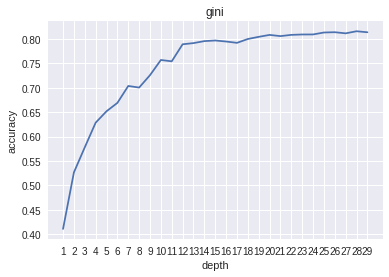

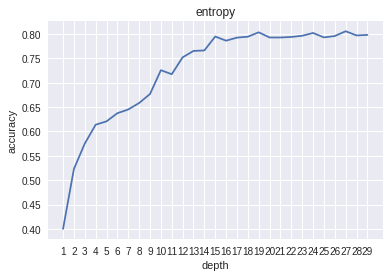

In [39]:
data=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/word2vec_gini.csv')
data1=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Decision_trees/word2vec_entropy.csv')
plot_graph(data,'gini')
plot_graph(data1,'entropy')

****For the depth 25,26,28 we are getting low error rate among all possible values of depth , so lets try these values****

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=25, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model=decision_tree.fit(train_vec,df_train_y)
output=model.predict(test_vec)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=26, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model1=decision_tree.fit(train_vec,df_train_y)
output1=model1.predict(test_vec)

In [0]:
decision_tree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=28, min_samples_split=2, min_samples_leaf=10, class_weight='balanced')
model2=decision_tree.fit(train_vec,df_train_y)
output2=model2.predict(test_vec)

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


done with confusion matrices
+-----------+--------+----------+----------+-------+
| precision | recall | accuracy | f1-score | depth |
+-----------+--------+----------+----------+-------+
|   0.921   | 0.835  |  0.793   |  0.876   |  25   |
+-----------+--------+----------+----------+-------+
|   0.921   | 0.836  |  0.794   |  0.877   |  26   |
+-----------+--------+----------+----------+-------+
|   0.92    | 0.834  |  0.792   |  0.875   |  28   |
+-----------+--------+----------+----------+-------+


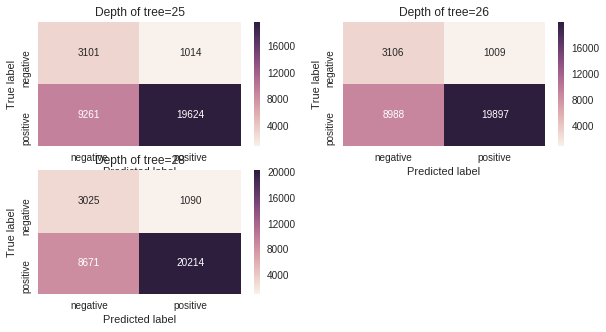

In [43]:
depth=[25,26,28]
plot_confusion_matrix(depth,output,output1,output2)
plot_table(depth,output,output1,output2)
#feature_importance([model,model1,model2],tfidf1_train)

**The models precision score is around 92% and recall score is 83% which means among true 100 reviews the model is able to predict 83% them correctly**

# Feature importance in word2vec

**weights in word2vec model doesnot correspond to the actual words , so feature imortance in word2vec doesnot make sense.**

# Conclusion

**analyzed decision tree algorithm with different vectorizations such as bag of words and tf_idf and word2vec and results are tabulated .**

**I visulized the decision tree with the help of graphviz module and understtod how a query point reaches to its class in the decision tree**

**After analyzing decision trees with all the vectorizations , word2vec is performing good  with an f1_score of around 87% among all the vetorizations. **